In [19]:
%matplotlib inline
import os
import sys

sys.path.append("../../../")

from sapsan.lib.backends import MLflowBackend, FakeBackend
from sapsan.lib.data import HDF5Dataset, EquidistantSampling, flatten
#from sapsan.lib.estimator.cnn.cnn3d_estimator import CNN3d, CNN3dConfig
from sapsan.lib import Train, Evaluate

In [37]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython import display
import numpy as np

def plot_params():
    params = {'font.size': 14, 'legend.fontsize': 14, 
              'axes.labelsize': 20, 'axes.titlesize':24,
              'xtick.labelsize': 17,'ytick.labelsize': 17,
              'axes.linewidth': 1, 'patch.linewidth': 3, 'lines.linewidth': 3,
              'xtick.major.width': 1.5,'ytick.major.width': 1.5,
              'xtick.minor.width': 1.25,'ytick.minor.width': 1.25,
              'xtick.major.size': 7,'ytick.major.size': 7,
              'xtick.minor.size': 4,'ytick.minor.size': 4,
              'xtick.direction': 'in','ytick.direction': 'in',              
              'axes.formatter.limits' : [-7, 7], 
              'axes.grid':True, 'grid.linestyle': ':', 'grid.color':'#999999',
              'text.usetex': False}              
    return params

class shock:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.shock_i = 0
        self.shock_r = 0
        
    def plot_plt(self, label=0, title='', shock=False, log='loglog', refresh=True, **kwargs):
        style = 'tableau-colorblind10'
        mpl.style.use(style)
        mpl.rcParams.update(plot_params())   

        plt.figure(figsize=(10,6))
        plt.gca().cla() 
        if log=='loglog': plt.loglog(self.x, self.y, label=label)
        elif log=='semilog': plt.semilogx(self.x, self.y, label=label)
        else: plt.plot(self.x, self.y, label=label)
            
        self.shock_position_rev()
        plt.axvline(self.shock_r, color='tab:red', label='shock')
        
        plt.legend(loc=3)
        
        if 'xmin' in kwargs: xmin = kwargs['xmin']
        if 'xmax' in kwargs: xmax = kwargs['xmax']; plt.xlim(xmin, xmax)
        if 'ymin' in kwargs: ymin = kwargs['ymin']
        if 'ymax' in kwargs: ymax = kwargs['ymax']; plt.ylim(ymin, ymax)
        
        plt.xlabel('r')
        plt.ylabel('Velocity')
        plt.title(title)
        if refresh:
            display.clear_output(wait=True)
            display.display(plt.gcf()) 
        return plt
    
    def shock_position(self):    
        self.shock_r = 0
        self.shock_i=np.argmin(self.y)
        self.shock_r = self.x[self.shock_i]
        #print('shock position: %.2e'%self.shock_r, self.shock_i)
        
def pns_radius(rho, rho_threshold=5e10):    
    for i in range(len(rho)-1,-1,-1):
        if rho[i] >= rho_threshold:
            pns_x = rho[i]
            pns_ind = i
            break
    return pns_ind

In [39]:
def process_var(var, v, new_r, pns_i,shock_i):
    f = interpolate.interp1d(np.arange(len(v))[pns_i:shock_i+1], var[pns_i:shock_i+1])
    return f(new_r)

def interp_var(x, y, mlin_grid_size):
    mlin_x = np.zeros((x.shape[0], x.shape[1], mlin_grid_size))
    mlin_y = np.zeros((y.shape[0], y.shape[1], mlin_grid_size))
    for i in range(x.shape[0]):
        v = x[i,0]
        sh = shock(np.arange(len(v)), v)
        sh.shock_position()
        #print(sh.shock_i, sh.shock_r)
        pns_i = pns_radius(x[i,1], rho_threshold=1e14)
        new_r = np.linspace(pns_i,sh.shock_i,mlin_grid_size)

        mlin_y[i,0] = process_var(y[i,0], v, new_r, pns_i,sh.shock_i)        
        
        for j in range(x.shape[1]): 
            mlin_x[i,j] = process_var(x[i,j], v, new_r, pns_i,sh.shock_i)
            
        print('Convective region from/to: ',pns_i, sh.shock_i)

    return mlin_x, mlin_y, pns_i,sh.shock_i

In [40]:
# Resolution: 678x128x256 (r x theta x phi): r, pi and 2pi respectively
# outter radius is 2e4 km (2e9 cm)

#comp0: Ye
#eos0: gas pressure
#eos1: sound speed
#eos2: Temperature
#eos3: entropy
#eos4: gamma_1
#The rad variables of relevance are Erad0, Erad1, Erad2 (0, 1, 2 corresponding to electron neutrinos, electron anti-neutrinos, and heavy neutrinos) energy densitivies, and analgously for Frad0,1,2.

#['Flux0_0', 'Flux0_1', 'Flux0_2', 'Flux1_0', 'Flux1_1', 'Flux1_2', 
#'Flux2_0', 'Flux2_1', 'Flux2_2', 'Pturb_s2', 'Time', 'comp0', 
#'eos0', 'eos1', 'eos2', 'eos3', 'eos4', 
#'lapse', 'lapse_edge', 'rho', 'u', 'u1', 'u2', 'u3', 
#'velocity0', 'velocity1', 'velocity2']

#path = "data/t{checkpoint:1.0f}/{feature}_dim32_fm15.h5"

smass = 's12.0'
base = f'/home/pkarpov/scratch/adam/{smass}.swbj15.horo.3d/'

path = base+"dump_{checkpoint:05d}.h5"

# velocity, rho, P_gas, Vsound, T, entropy
features_label = ['u1','rho','eos0','eos1','eos2','eos3']
target_label = ['Pturb_s2']
#target_label = ['u1']
target = ['dummy']

#Dimensionality of your data in format (D,H,W)
INPUT_SIZE = [678]

#Reduce dimensionality to the following in format (D,H,W)
#SAMPLE_TO = (16,16,16)

#Sampler to use for reduction
#sampler = EquidistantSampling(SAMPLE_TO)

In [67]:
from scipy import interpolate
import numpy as np
checkpoints = [30,40,50,60,70,80,90,100,110,
               120,130,140,150,160,170,180,200,210,
               115,125,135,145,155,165,175,
               117,127,137,147]#,180,
               #187,200,210]#,220,230,240,250,260,
               #270,280,290,300]
#checkpoints = [100]

grid = HDF5Dataset(path= base+'grid.h5',
                          features_label=['Z'],
                          checkpoints=[0],
                          input_size=INPUT_SIZE)
r = grid.load_numpy().flatten()[:-1]

data_loader = HDF5Dataset(path=path,                        
                          features_label=['Time'],                          
                          checkpoints=checkpoints,
                          input_size=INPUT_SIZE,                          
                          shuffle = False,
                          train_fraction = len(checkpoints)-6)
time = data_loader.load_numpy()[0,0,0]

#Load the data
data_loader = HDF5Dataset(path=path,
                          target=target,
                          features_label=features_label,
                          target_label=target_label,
                          checkpoints=checkpoints,
                          input_size=INPUT_SIZE,
                          #sampler=sampler,
                          shuffle = False,
                          train_fraction = len(checkpoints)-6)

x, y = data_loader.load_numpy()
mlin_grid_size = 200

mlin_x, mlin_y, pns_i, shock_i = interp_var(x, y, mlin_grid_size)

#mlin_xt, mlin_yt, pns_i, shock_i = interp_var(mlin_x, mlin_y, 214)

print('shapes', x.shape,y.shape)
print('mlin_x', mlin_x.shape,mlin_y.shape)
#print('mlin_xt', mlin_xt.shape,mlin_yt.shape)

#mlin_x = mlin_x[:,2:3,:]

# Conversions in Fortran
#                      write(69,103)i,encm(i),1.d9*x(i),2.d6*rho(i),      &
# !     &                    1.d8*v(i),ye(i),1.d16*pr(i)!,                  &
#      &                    1.d8*v(i),ye(i),2.d22*pr(i),                  &
#      &                    1.d9*temp(i)   

# I think Adam's dataset uses 1e9 k for T units

units = {'u1':1e-8,
         'rho':2e-13,#2e-6,
         'eos0':2e-32,
         'eos1':1e-8,
         'eos2':1,
         'eos3':1,
         target_label[0]:1e1
         }

for i in range(mlin_x.shape[1]):
    if 'eos0' in features_label[i]: mlin_y[:,0] = mlin_y[:,0]/mlin_x[:,i] * units[target_label[0]]                  
    mlin_x[:,i] *= units[features_label[i]]
    print(f'{features_label[i]} min: {np.amin(mlin_x[:,i]):.3e}, max: {np.amax(mlin_x[:,i]):.3e}')   

print(f'Pturb/Pgas min: {np.amin(mlin_y[:,:]):.3e}, max: {np.amax(mlin_y[:,:]):.3e}')

loaders = data_loader.convert_to_torch([mlin_x, mlin_y])
print('Time %.2f ms'%(time*1e3))
print(pns_i, shock_i, r[pns_i], r[shock_i])

Features:  ['None']
Fetures_label: ['Z']
Loading 'Z' from file '/home/pkarpov/scratch/adam/s12.0.swbj15.horo.3d/grid.h5'
----------
Features:  ['None']
Fetures_label: ['Time']
Loading 'Time' from file '/home/pkarpov/scratch/adam/s12.0.swbj15.horo.3d/dump_00030.h5'
----------
Loading 'Time' from file '/home/pkarpov/scratch/adam/s12.0.swbj15.horo.3d/dump_00040.h5'
----------
Loading 'Time' from file '/home/pkarpov/scratch/adam/s12.0.swbj15.horo.3d/dump_00050.h5'
----------
Loading 'Time' from file '/home/pkarpov/scratch/adam/s12.0.swbj15.horo.3d/dump_00060.h5'
----------
Loading 'Time' from file '/home/pkarpov/scratch/adam/s12.0.swbj15.horo.3d/dump_00070.h5'
----------
Loading 'Time' from file '/home/pkarpov/scratch/adam/s12.0.swbj15.horo.3d/dump_00080.h5'
----------
Loading 'Time' from file '/home/pkarpov/scratch/adam/s12.0.swbj15.horo.3d/dump_00090.h5'
----------
Loading 'Time' from file '/home/pkarpov/scratch/adam/s12.0.swbj15.horo.3d/dump_00100.h5'
----------
Loading 'Time' from file

In [56]:
import h5py
with h5py.File(base+'grid.h5', 'r') as hf:
    print(hf.keys())
    vol = hf['volume']
    z = hf['Z']
    print(vol.shape,z.shape)    

with h5py.File(base+'dump_00009.h5', 'r') as hf:
    print(hf.keys())    
    Pturb = hf['Pturb_s2']
    v = hf['velocity0']
    print(v.shape, Pturb.shape)

<KeysViewHDF5 ['X', 'Y', 'Z', 'area0', 'area1', 'area2', 'gcov0', 'gcov1', 'gcov2', 'mask', 'volume']>
(678,) (679,)
<KeysViewHDF5 ['Flux0_0', 'Flux0_1', 'Flux0_2', 'Flux1_0', 'Flux1_1', 'Flux1_2', 'Flux2_0', 'Flux2_1', 'Flux2_2', 'Pturb_s2', 'Time', 'comp0', 'eos0', 'eos1', 'eos2', 'eos3', 'eos4', 'lapse', 'lapse_edge', 'rho', 'u', 'u1', 'u2', 'u3', 'velocity0', 'velocity1', 'velocity2']>
(678,) (678,)


In [68]:
import json
import numpy as np
import sys
import os

import torch
from torch.autograd import Variable
from torch.utils import data
from torch.utils.data import DataLoader

from sapsan.core.models import EstimatorConfig
from sapsan.lib.estimator.torch_backend import TorchBackend
from sapsan.lib.data import get_loader_shape

from sapsan.lib.estimator.torch_modules import Interp1d
from sapsan.lib.estimator.torch_modules import Gaussian

class PIMLTurbModel(torch.nn.ModuleDict):
    def __init__(self, D_in = 1, D_out = 1, activ = "ReLU", sigma=1):
        super(PIMLTurbModel, self).__init__()       
        
        D_out=200
            
        self.conv1d = torch.nn.Conv1d(D_in, D_in*2, kernel_size=2, stride=2)
        #self.conv3d = torch.nn.Conv3d(D_in, D_in*2, kernel_size=2, stride=1)

        self.pool = torch.nn.MaxPool1d(kernel_size=2)

        self.activation = getattr(torch.nn, activ)()

        #self.linear = torch.nn.Linear(D_in*8, D_in*16)
        self.linear = torch.nn.Linear(D_in*100, D_in*200)
        self.linear2 = torch.nn.Linear(D_in*200, D_out)
        
        self.gaussian = Gaussian(sigma=1)

    def forward(self, x):         
        #x = x.double()
        x = x.float()
        x_shape = x.size()
        
        show = False
        if show: print(x_shape)
        x = self.conv1d(x)        
        if show: print(x.size())
        x = self.pool(x)
        if show: print(x.size())
        
        x = self.activation(x) 
        x = x.view(x.size(0), -1)
        if show: print(x.size())
        x = self.linear(x)
        if show: print(x.size())
        x = self.activation(x)
        x = self.linear2(x) 
        
        x_shape = list(x_shape)
        #del x_shape[1]
        x_shape[1]=1
        x = torch.reshape(x,x_shape)  
        if show: print(x.size())        
        x = torch.mul(x,x)
        #x = torch.sqrt(x)
        if show: print(x.size())
        #x = self.gaussian(x)
        return x          

class SmoothL1_KSLoss(torch.nn.Module):
    '''
    The loss functions combines a statistical (Kolmogorov-Smirnov)
    and a spatial loss (Smooth L1).
    
    Corresponding 'train_l1ks_log.txt' and 'valid_l1ks_log.txt'
    are written out to include the individual loss evolutions.
    '''    
    def __init__(self, ks_stop, ks_frac, ks_scale, l1_scale, beta, train_size, valid_size):
        super(SmoothL1_KSLoss, self).__init__()
        self.first_write = True
        self.first_iter = True
        self.ks_stop = ks_stop
        self.ks_frac = ks_frac
        self.ks_scale = ks_scale        
        self.l1_scale = l1_scale
        self.beta = beta
        self.train_size = train_size
        self.valid_size = valid_size
        self.stop = False   
        
    def write_log(self, losses):
        if self.first_write:
            if os.path.exists(self.log_fname): os.remove(self.log_fname)
        
        with open(self.log_fname,'a') as f:
            if self.first_write:
                f.write(f"mean(L1_loss) \t mean(KS_loss) "\
                        f"\t mean(L1_loss)*{self.l1_scale:.3e} \t mean(KS_loss)*{self.ks_scale:.3e}")
            f.write("\n")
            np.savetxt(f, losses.detach().cpu().numpy(), fmt='%.3e', newline="\t")
            
    def forward(self, predictions, targets, write, write_idx):  
        if predictions.is_cuda:
            self.device = torch.device('cuda:%d'%predictions.get_device()) 
        else: self.device = torch.device('cpu')       
        
        #-----SmoothL1----
        l1_loss = 0

        self.beta = 0.1*targets.max()
        diff = predictions-targets
        mask = (diff.abs() < self.beta)
        l1_loss += mask * (0.5*diff**2 / self.beta)
        l1_loss += (~mask) * (diff.abs() - 0.5*self.beta)
           
        #--------KS-------
        distr = torch.distributions.normal.Normal(loc=targets.mean(), 
                                                  scale=targets.std(), 
                                                  validate_args=False)  
        cdf,idx = distr.cdf(targets).flatten().to(self.device).sort()
        
        distr = torch.distributions.normal.Normal(loc=predictions.mean(), 
                                                  scale=predictions.std(), 
                                                  validate_args=False) 
        cdf_pred,idx_pred = distr.cdf(predictions).flatten().to(self.device).sort()     
                                
        vals,idx = targets.flatten().to(self.device).sort()
        vals_pred,idx_pred = predictions.flatten().to(self.device).sort()        

        cdf_interp = Interp1d()(vals_pred, cdf_pred, vals)[0]       
        
        ks_loss = torch.max(torch.abs(cdf-cdf_interp)).to(self.device)           
        
        #--Print Metrics-- 
        if self.first_iter:
            self.maxl1 = l1_loss.mean().detach()                      
            self.maxks = ks_loss.mean().detach()
            self.max_ratio = self.maxks/self.maxl1
                        
            print('---Initial (max) L1, KS losses and their ratio--')
            print(self.maxl1, self.maxks, self.max_ratio)
            print('------------------------------------------------')
            
            self.first_iter = False

        #----Calc Loss----
        #fractions that KS and L1 contribute to the total loss        
        l1_frac = 1-self.ks_frac
        
        loss = (l1_frac*l1_loss.mean()*self.l1_scale +
                self.ks_frac*ks_loss.mean()*self.ks_scale)
        
        #---Save Batch----
        if write_idx == 0:
            if write == 'train': 
                self.batch_size = self.train_size
                self.log_fname = "train_l1ks_log.txt"
            elif write == 'valid': 
                self.batch_size = self.valid_size 
                self.log_fname = "valid_l1ks_log.txt"                
            self.iter_losses_l1 = torch.zeros(self.batch_size,requires_grad=False).to(self.device)
            self.iter_losses_ks = torch.zeros(self.batch_size,requires_grad=False).to(self.device)
        
        self.iter_losses_l1[write_idx] = l1_loss.mean().detach()
        self.iter_losses_ks[write_idx] = ks_loss.mean().detach()
        
        #---Write Logs----
        if write_idx == (self.batch_size-1):
            mean_iter_l1 = self.iter_losses_l1.mean()
            mean_iter_ks = self.iter_losses_ks.mean()
            
            if mean_iter_ks < self.ks_stop or self.stop==True:
                self.stop = True
            
            self.write_log(torch.tensor([mean_iter_l1, mean_iter_ks,
                                         mean_iter_l1*self.l1_scale,
                                         mean_iter_ks*self.ks_scale]))      
            if write == 'valid': self.first_write = False                  
        
        return loss, self.stop
    
class PIMLTurbConfig(EstimatorConfig):
    def __init__(self,
                 n_epochs: int = 1,
                 patience: int = 10,
                 min_delta: float = 1e-5, 
                 logdir: str = "./logs/",
                 lr: float = 1e-3,
                 min_lr = None,                 
                 *args, **kwargs):
        self.n_epochs = n_epochs
        self.logdir = logdir
        self.patience = patience
        self.min_delta = min_delta
        self.lr = lr
        if min_lr==None: self.min_lr = lr*1e-2
        else: self.min_lr = min_lr        
        self.kwargs = kwargs
        self.parameters = {f'model - {k}': v for k, v in self.__dict__.items() if k != 'kwargs'}
        if bool(self.kwargs): self.parameters.update({f'model - {k}': v for k, v in self.kwargs.items()})          
    
class PIMLTurb(TorchBackend):
    def __init__(self, activ, loss,
                       loaders,
                       ks_stop = 0.1,
                       ks_frac = 0.5,
                       ks_scale = 1,
                       l1_scale = 1,                 
                       l1_beta = 1,
                       sigma = 1,
                       config = PIMLTurbConfig(), 
                       model = PIMLTurbModel()):
        super().__init__(config, model)
        self.config = config
        self.loaders = loaders
        self.device = self.config.kwargs['device']
        self.ks_stop = ks_stop
        self.ks_frac = ks_frac
        self.ks_scale = ks_scale
        self.l1_scale = l1_scale        
        self.beta = l1_beta
        
        x_shape, y_shape = get_loader_shape(self.loaders)                

        self.model = PIMLTurbModel(x_shape[1], y_shape[2]**3, activ, sigma)
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.config.lr)        
        
        if loss == "SmoothL1_KSLoss": 
            self.loss_func = SmoothL1_KSLoss(ks_stop = self.ks_stop, ks_frac = self.ks_frac,
                                             ks_scale = self.ks_scale, l1_scale = self.l1_scale, 
                                             beta = self.beta,
                                             train_size = len(self.loaders['train']), 
                                             valid_size = len(self.loaders['valid']))
        else: 
            print("This network only supports the custom SmoothL1_KSLoss. Please set the 'loss' parameter in config")
            sys.exit()
        
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer,
                                                               patience=self.config.patience,
                                                               min_lr=self.config.min_lr) 
        self.config.parameters["model - loss"] = str(self.loss_func).partition("(")[0]
        self.config.parameters["model - activ"] = activ
        
    def write_loss(self, losses, epoch, fname_train = "train_log.txt", fname_valid='valid_log.txt'):
        for idx, fname in enumerate([fname_train, fname_valid]):
            if epoch==1:
                if os.path.exists(fname): os.remove(fname)

            with open(fname,'a') as f:
                if epoch == 1: f.write("epoch \t loss")
                f.write("\n")
                np.savetxt(f, [[losses[0],losses[idx+1]]], fmt='%d \t %.3e', newline="\t")
        
    def train(self):    
        self.model = self.model#.double()
        self.model.to(self.device)
        
        if 'cuda' in str(self.device):
            self.optimizer_to(self.optimizer, self.device)      
            
        for epoch in np.linspace(1,int(self.config.n_epochs),int(self.config.n_epochs), dtype='int'):     
            iter_loss = np.zeros(len(self.loaders['train']))
            for idx, (x, y) in enumerate(self.loaders['train']):
                x = x.to(self.device)
                y = y.to(self.device)
                
                y_pred = self.model(x)
                loss, stop = self.loss_func(y_pred, y, 'train', idx)
                
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                
                iter_loss[idx] = loss.item()
                        
            epoch_loss = iter_loss.mean()
            print(f'train ({epoch}/{int(self.config.n_epochs)}) loss: {epoch_loss:.4e}')
                        
            with torch.set_grad_enabled(False):
                iter_loss_valid = np.zeros(len(self.loaders['valid']))
                for idx, (x, y) in enumerate(self.loaders['valid']):
                    x = x.to(self.device)
                    y = y.to(self.device)

                    y_pred = self.model(x)                                    
                    
                    loss_valid, stop = self.loss_func(y_pred, y, 'valid', idx)

                    iter_loss_valid[idx] = loss_valid.item()

                epoch_loss_valid = iter_loss_valid.mean()
                print(f'valid ({epoch}/{int(self.config.n_epochs)}) loss: {epoch_loss_valid:.4e}')
            
            self.write_loss([epoch, epoch_loss, epoch_loss_valid], epoch)            
            
            if stop:
                print('Reached sufficient KS Loss, stopping...')
                break
                    
            print('-----')  

        with open('model_details.txt', 'w') as file:                    
            file.write('%s\n\n%s\n\n%s'%(str(self.model),
                                   str(self.optimizer),
                                   str(self.scheduler)))
                
        return self.model

In [77]:
#estimator = CNN3d(config = CNN3dConfig(n_epochs=5, patience=10, min_delta=1e-5),
#                  loaders = loaders)

# print(f'Target: {torch.amin(targets):.2e}, {torch.amax(targets):.2e}')
# print(f'Predic: {torch.amin(predictions):.2e}, {torch.amax(predictions):.2e}')

lr = 1e-4
#loss = "SmoothL1Loss"
#loss = "CustomLoss"
#loss = "KSLoss2"
loss = "SmoothL1_KSLoss"
#loss = "MSELoss"
#loss = "BCELoss"
#loss = "BCEWithLogitsLoss"
#activ = "LogSigmoid"
activ = "Tanhshrink"
#activ = "Sigmoid"
#activ = "ReLU"
ks_stop = 0.004
l1_scale = 1e4#e-15
ks_scale = 1#5e8#5e16

mlflow = True
#mlflow = False
if mlflow: 
    experiment_name = smass
    tracking_backend = MLflowBackend(experiment_name, host="localhost",port=5000)
else: tracking_backend = FakeBackend()

estimator = PIMLTurb(
        config = PIMLTurbConfig(n_epochs=1500, patience=10, 
                             min_delta=1e15, lr=lr, min_lr=lr*1e-5, 
                             device='cpu', loader_key='train'),
        loaders = loaders,
        activ=activ, loss=loss,
        ks_stop = ks_stop,
        l1_scale = l1_scale,
        ks_scale = ks_scale,
        l1_beta = 1,
        sigma = 1)    

localhost:5000 is busy, checking if it is MLflow...
mlflow ui is already running at localhost:5000


In [78]:
#--- Train the model ---
#Set the experiment
    
training_experiment = Train(model=estimator,
                            backend=tracking_backend,
                            data_parameters = data_loader)

#Train the model
estimator = training_experiment.run()
if mlflow: 
    tracking_backend.log_parameter("ks_stop", ks_stop)
    tracking_backend.log_parameter("ks_scale", ks_scale)
    tracking_backend.log_parameter("l1_scale", l1_scale)

---Initial (max) L1, KS losses and their ratio--
tensor(8.0627) tensor(0.7223) tensor(0.0896)
------------------------------------------------
train (1/1500) loss: 4.9382e+03
valid (1/1500) loss: 9.6297e+02
-----
train (2/1500) loss: 9.7227e+02
valid (2/1500) loss: 4.4657e+02
-----
train (3/1500) loss: 8.4780e+02
valid (3/1500) loss: 4.3429e+02
-----
train (4/1500) loss: 7.5562e+02
valid (4/1500) loss: 5.0847e+02
-----
train (5/1500) loss: 6.8042e+02
valid (5/1500) loss: 4.6289e+02
-----
train (6/1500) loss: 6.3655e+02
valid (6/1500) loss: 4.1662e+02
-----
train (7/1500) loss: 6.0402e+02
valid (7/1500) loss: 3.6577e+02
-----
train (8/1500) loss: 6.0872e+02
valid (8/1500) loss: 4.6212e+02
-----
train (9/1500) loss: 5.3573e+02
valid (9/1500) loss: 3.6203e+02
-----
train (10/1500) loss: 5.9401e+02
valid (10/1500) loss: 3.9799e+02
-----
train (11/1500) loss: 5.9554e+02
valid (11/1500) loss: 4.3840e+02
-----
train (12/1500) loss: 4.9513e+02
valid (12/1500) loss: 2.7985e+02
-----
train (13/1

In [79]:
from sapsan.utils.plot import log_plot
#plotting training results
#Note: not done automatically since Catalyst is NOT used
log = log_plot(show_log=True,
               log_path = 'train_log.txt', 
               valid_log_path = 'valid_log.txt', 
               delimiter = '\t')
log_name = "runtime_log.html"
if mlflow:
    log.write_html(log_name)
    tracking_backend.log_artifact(log_name)

#--------------------------------------------------
#plotting individual evolutions of L1 and KS losses
#Note: the individual losses are not logged at every epoch
#mean(L1_loss)    mean(KS_loss)
#mean(L1_loss)*{self.scalel1:.3e}     mean(KS_loss)*{self.scalel1:.3e}
losses = [[f"mean(L1_loss)", f"mean(L1_valid)"],
          [f"mean(KS_loss)", f"mean(KS_valid)"]]

for idx, (train_name, valid_name) in enumerate(losses):
    if 'L1' in train_name: idx = 2 #plotting scaled L1
    elif 'KS' in train_name: idx = 1
    log = log_plot(show_log=True, 
                   valid_log_path = 'valid_l1ks_log.txt',
                   log_path = 'train_l1ks_log.txt',
                   delimiter = '\t',
                   train_name=train_name, valid_name=valid_name,
                   train_column=idx, valid_column=idx, epoch_column=None)
    log_name = f"{train_name}.html"
    if mlflow:
        log.write_html(log_name)    
        tracking_backend.log_artifact(log_name) 

In [70]:
# model_scripted = torch.jit.script(estimator.model) # Export to TorchScript
# model_scripted.save('model_scripted_1e-8.pt')

Features:  ['None']
Fetures_label: ['u1', 'rho', 'eos0', 'eos1', 'eos2', 'eos3']
Loading 'u1' from file '/home/pkarpov/scratch/adam/s12.0.swbj15.horo.3d/dump_00151.h5'
----------
Loading 'rho' from file '/home/pkarpov/scratch/adam/s12.0.swbj15.horo.3d/dump_00151.h5'
----------
Loading 'eos0' from file '/home/pkarpov/scratch/adam/s12.0.swbj15.horo.3d/dump_00151.h5'
----------
Loading 'eos1' from file '/home/pkarpov/scratch/adam/s12.0.swbj15.horo.3d/dump_00151.h5'
----------
Loading 'eos2' from file '/home/pkarpov/scratch/adam/s12.0.swbj15.horo.3d/dump_00151.h5'
----------
Loading 'eos3' from file '/home/pkarpov/scratch/adam/s12.0.swbj15.horo.3d/dump_00151.h5'
----------
Loading 'Pturb_s2' from file '/home/pkarpov/scratch/adam/s12.0.swbj15.horo.3d/dump_00151.h5'
----------
Convective region from/to:  20 229
u1 min: -3.308e+01, max: 8.123e-02
rho min: 4.501e-06, max: 2.375e+01
eos0 min: 2.270e-07, max: 5.626e+01
eos1 min: 7.338e+00, max: 6.847e+01
eos2 min: 4.997e-01, max: 2.690e+01
eos3 

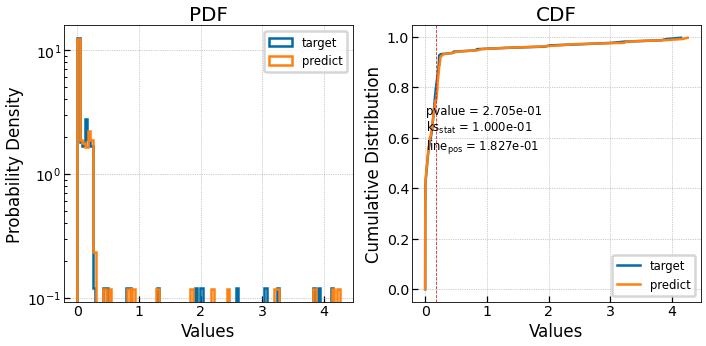

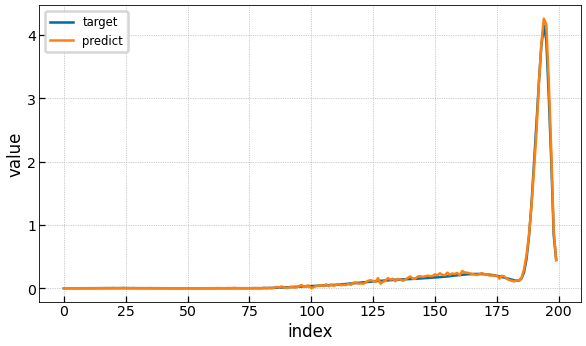

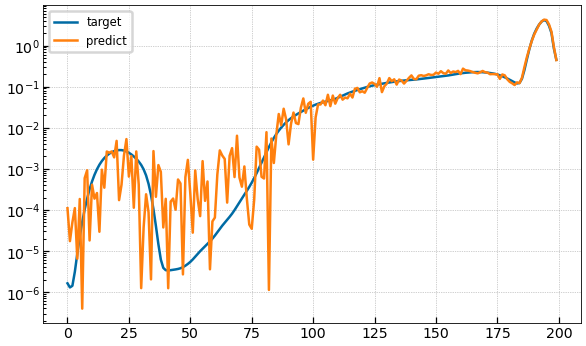

In [80]:
%matplotlib inline

#--- Test the model ---
#Load the test data
data_loader_eval = HDF5Dataset(path=path,
                          target=target,
                          features_label=features_label,
                          target_label=target_label,
                          checkpoints=[151],
                          input_size=INPUT_SIZE)
x, y = data_loader_eval.load_numpy()

#x[:,3] = x[:,3]#/2e22
#y[:,0] = y[:,0]#/2e22

mlin_x, mlin_y, pns_i, shock_i = interp_var(x, y, mlin_grid_size)

for i in range(mlin_x.shape[1]):
    if 'eos0' in features_label[i]: mlin_y[:,0] = mlin_y[:,0]/mlin_x[:,i] * units[target_label[0]]                  
    mlin_x[:,i] *= units[features_label[i]]
    print(f'{features_label[i]} min: {np.amin(mlin_x[:,i]):.3e}, max: {np.amax(mlin_x[:,i]):.3e}')

print(f'Pturb min: {np.amin(mlin_y[:,:]):.3e}, max: {np.amax(mlin_y[:,:]):.3e}')

loaders = data_loader_eval.convert_to_torch([mlin_x, mlin_y])

#Set the test experiment
estimator.loaders = loaders
data_loader_eval.input_size=[mlin_grid_size]
data_loader_eval.batch_size=[mlin_grid_size]

evaluation_experiment = Evaluate(model = estimator,
                                 backend=tracking_backend,
                                 data_parameters = data_loader_eval,
                                 )#pdf_xlim = (-0.5e7,2e7),
                                 #cdf_xlim = (-0.5e7,2e7))

#Test the model
#eval returns a dict, cubes = {'pred_cube':np.ndarray, 'target_cube':np.ndarray}
cubes = evaluation_experiment.run()

from sapsan.utils.plot import cdf_plot, pdf_plot, line_plot

targ = cubes['target']
pred = cubes['predict']

print(f'Target: {np.amin(targ):.2e}, {np.amax(targ):.2e}')
print(f'Predic: {np.amin(pred):.2e}, {np.amax(pred):.2e}')

ax = line_plot([[np.arange(mlin_grid_size),targ[0,0]/1e0],
                [np.arange(mlin_grid_size),pred[0,0]/1e0],
                ],label=['target', 'predict'],
                plot_type='semilogy', figsize = (10,6))

run_id = evaluation_experiment.run_id
tracking_backend.resume(run_id = run_id)
logy_name = 'spatial_plot_logy.png'
if mlflow:
    plt.savefig(logy_name)
    tracking_backend.log_artifact(logy_name) 
tracking_backend.end()       

In [ ]:
#80, 93
'''
sols = [9 155
        10 420
        12 211
        13 529
        14 529
        15 55
        16 157
        17 157
        18 157
        19 210
        20 314
        25 309
        60 400
'''
#m = torch.nn.Linear(20,30)
#input = torch.randn(128,20)
m = torch.nn.Linear(192,384)
input = torch.randn(1,192)
output = m(input)
print(output.size())

In [ ]:
import h5py as h5

with ('/home/pkarpov/COLLAPSO1D/project/1dmlmix/DataOut/DataOut_read.250') as hf:
    